In [1]:
from tidyverse.dummy import *
import scanpy as sc
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import decoupler as dc
import sys
from colormaps import color_dict_diagnosis
import sys
sys.path.append('..')
from util import load_original_data, load_validation_data

def plot_pca(df_pca, var_explained, pc1='PC1', pc2='PC2', color='diagnosis'):

    var_explained = {f"PC{i+1}": var_explained[i] for i in range(len(var_explained))}
    p = (
        pn.ggplot(df_pca)
        + pn.aes(pc1, pc2, color=color, label='samplename')
        + pn.geom_point(size=5) 
        + pn.theme(figure_size=(4,3))
        + pn.labs(x=f"{pc1} ({var_explained[pc1]*100:.2f}%)", y=f'{pc2} ({var_explained[pc2]*100:.2f}%)')
    )
    return p

Importing tidyverse


PCA was calculated in R, let's wrap this qith rpy2

In [2]:
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import numpy as np
import anndata2ri

ro.r('''
#library(tidyverse)
library(dplyr)

log2p <- function(x) { log2(x+1) }

pca_df_expr <- function(pseudo, meta, ngenes) {

    counts <- pseudo     %>% mutate_if(is.numeric, log2p)
    rowmin = apply(counts %>% select(where(is.numeric)), 1, min)
    counts = counts %>% 
        mutate(mysum = rowmin) %>%
        filter( mysum > 0) %>% filter(mysum<2000) %>%
        select(-mysum)

    variances = apply(counts %>% select(where(is.numeric)), 1, var)
    counts = counts %>% 
        mutate(v=variances) %>% 
        arrange(desc(v)) %>% 
        select(-v) %>%
        head(ngenes)

    counts_for_pca = counts # %>% select(-id)
    sub_pca <- prcomp(counts_for_pca, center = TRUE, scale = TRUE)
    
    rotation_df <- as.data.frame(sub_pca$rotation)
    rotation_df$biosample = rownames(rotation_df)

    meta$biosample = rownames(meta)
    df <- dplyr::inner_join(rotation_df, meta)
    return(list("df"=df, "sdev"=sub_pca$sdev))
}
'''
)

def pca_in_r(pdata):
    with localconverter(ro.default_converter + anndata2ri.converter):
        ro.globalenv['scanpy.data'] = pdata
    ro.r('counts = as.data.frame(assay(scanpy.data))');
    ro.r('coldata = as.data.frame(colData(scanpy.data))');
    ro.r('res = pca_df_expr(counts, coldata, 100)')
    with localconverter(ro.default_converter + pandas2ri.converter):
        df_pca = ro.r('res$df')
        df_sdev = ro.r('res$sdev')
    df_sdev = df_sdev / df_sdev.sum()
    return df_pca, df_sdev

def do_pb(adata):
    return dc.get_pseudobulk(
        adata,
        sample_col='samplename',
        groups_col=None,
        mode='sum',
        min_cells=20,
        min_counts=0,
    )

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Primary Data

In [3]:
adata = load_original_data()

In [4]:
tissues = {
    'epi': ["epithelial_columnar", "epithelial_squamous"],
    'immune': ["immune"],
    'stroma' : ["stromal"],
    'all' :  ["epithelial_columnar", "epithelial_squamous", "immune", "stromal", "other"]
}

pdata_dict = {
    name: do_pb(adata[adata.obs.tissue_split.isin(splits)])
    for name, splits in tissues.items()
}

In [5]:
plots = []
for split, pdata in pdata_dict.items():
    df_pca, var_explained = pca_in_r(pdata)
    # p = plot_pca(df_pca, var_explained, 'PC1','PC2') + pn.scale_color_manual(color_dict_diagnosis) + pn.labs(title=split)
    p = plot_pca(df_pca, var_explained, 'PC2','PC3') + pn.scale_color_manual(color_dict_diagnosis) + pn.labs(title=split)
    plots.append(p)
plt.show()

Joining with `by = join_by(biosample)`
Joining with `by = join_by(biosample)`
Joining with `by = join_by(biosample)`
Joining with `by = join_by(biosample)`


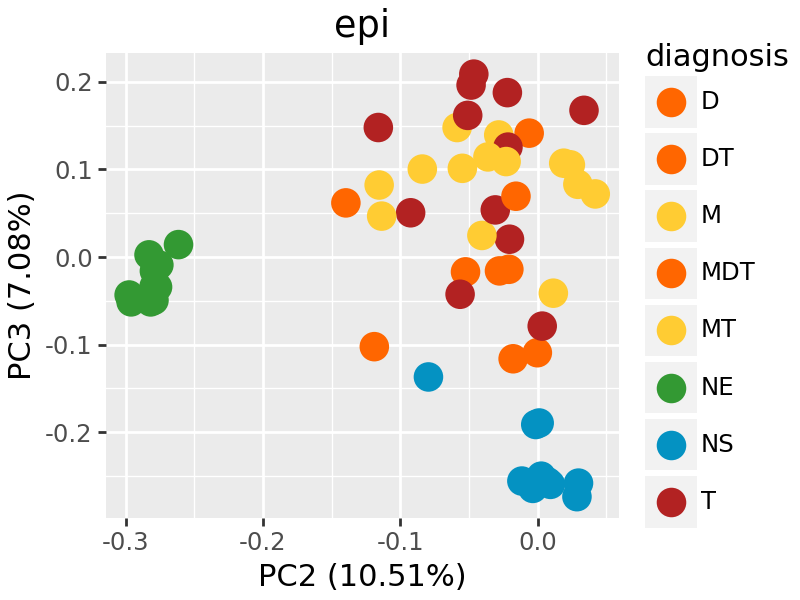

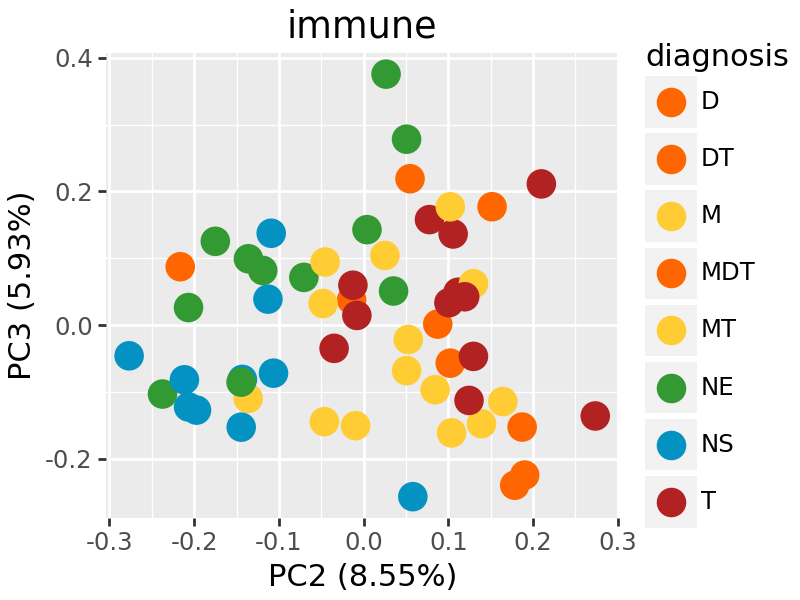

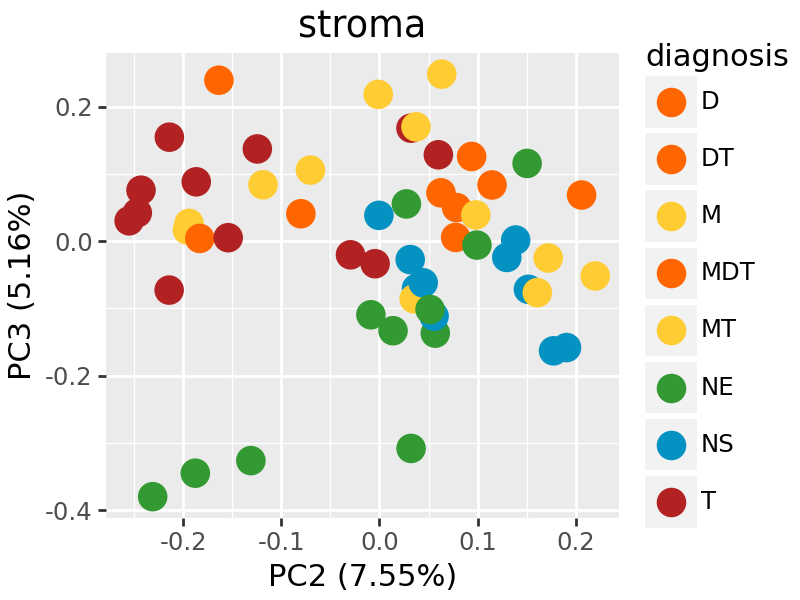

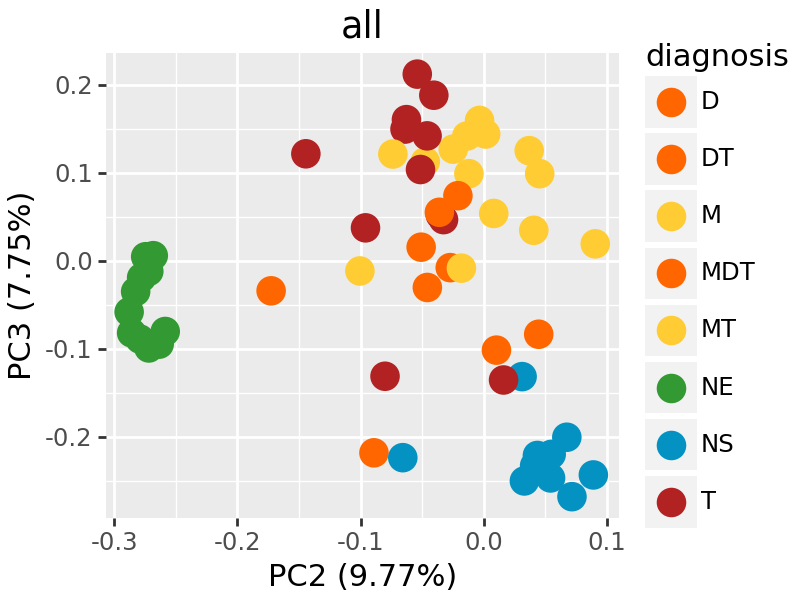

[None, None, None, None]

In [6]:
[_.show() for _ in plots]

# Validation Data

In [7]:
adata = load_validation_data()

In [8]:
tissues = {
    'epi': ["epithelial_columnar", "epithelial_squamous"],
    'immune': ["immune"],
    'stroma' : ["stromal"],
    'all' :  ["epithelial_columnar", "epithelial_squamous", "immune", "stromal", "other"]
}

pdata_dict = {
    name: do_pb(adata[adata.obs.tissue_split.isin(splits)])
    for name, splits in tissues.items()
}

In [9]:
plots = []
for split, pdata in pdata_dict.items():
    df_pca, var_explained = pca_in_r(pdata)
    # p = plot_pca(df_pca, var_explained, 'PC1','PC2') + pn.scale_color_manual(color_dict_diagnosis) + pn.labs(title=split)
    p = plot_pca(df_pca, var_explained, 'PC2','PC3') + pn.scale_color_manual(color_dict_diagnosis) + pn.labs(title=split)
    plots.append(p)
plt.show()

Joining with `by = join_by(biosample)`
Joining with `by = join_by(biosample)`
Joining with `by = join_by(biosample)`
Joining with `by = join_by(biosample)`


/opt/conda/lib/python3.11/site-packages/plotnine/scales/scale_manual.py:39: PlotnineWarning: The palette of scale_color_manual can return a maximum of 8 values. 9 were requested from it.


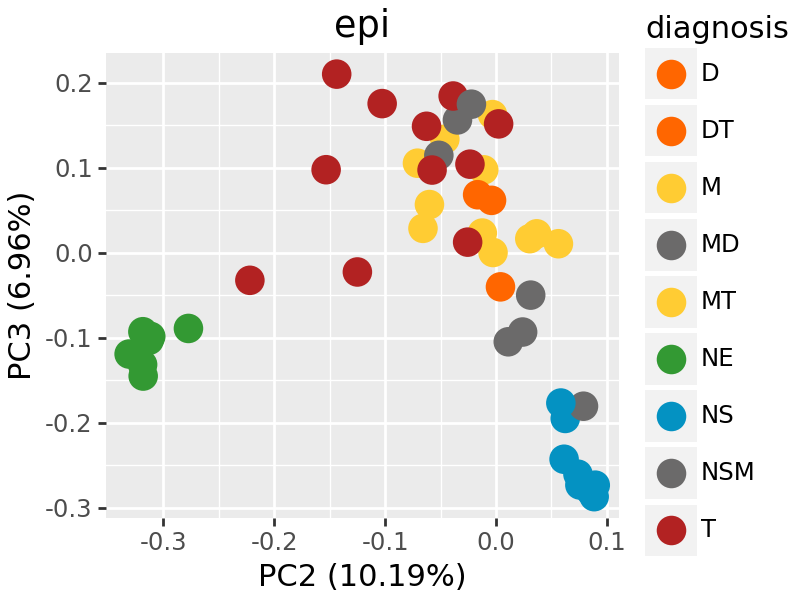

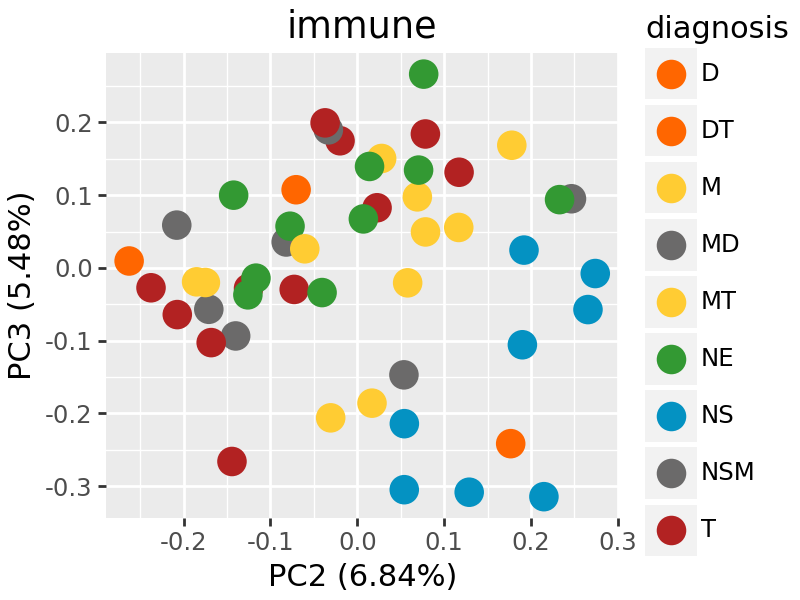

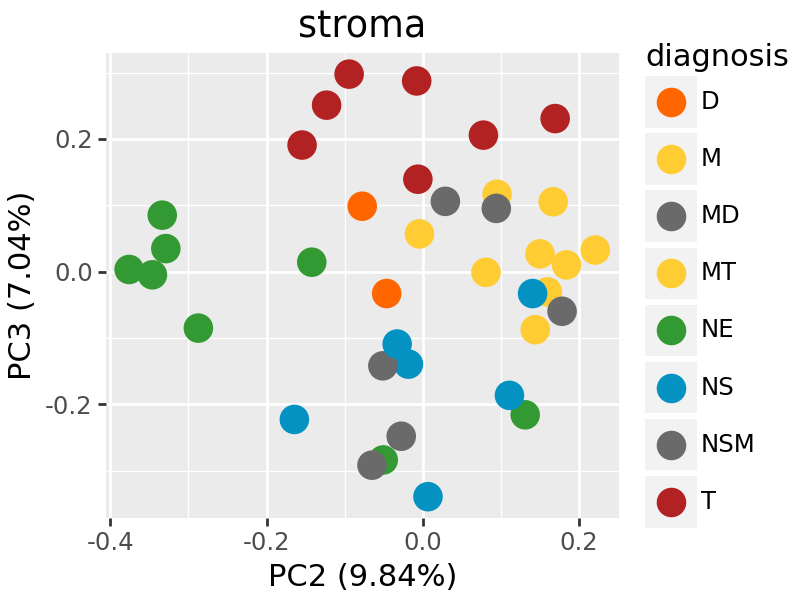

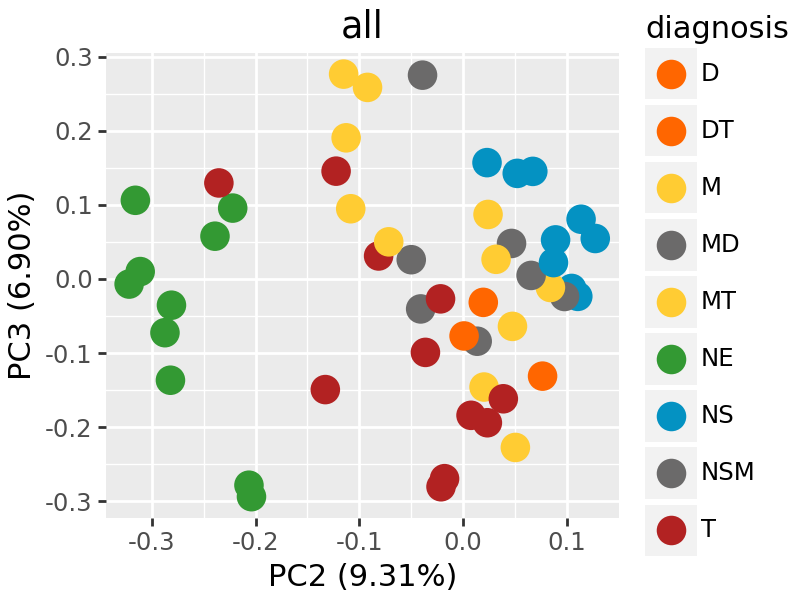

[None, None, None, None]

In [10]:
[_.show() for _ in plots]